Cloning the repository.

In [1]:
!apt-get install git
!git config --global user.email "mona.mahmoodi@gmail.com"
!git config --global user.name "mona1378"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
!git clone https://github.com/Pivotal-Life-Sciences-DS/mona_takehome

Cloning into 'mona_takehome'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 866.69 KiB | 2.79 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
%cd mona_takehome/

/content/mona_takehome


Reading the chess data.

In [11]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('chess_games.csv', delimiter='\t')

# Display the first few rows to understand the structure
print(df.head())
print(df.shape)
df['black_opening_score'].describe()

    timestamp  outcome  moves_count white_username  white_rating  \
0  1630368486        0           64  ieshuaganocry          1901   
1  1630524120        1           20      endriu777          1870   
2  1630522980        0           40     hooligandi          1808   
3  1630522530        1           34  ieshuaganocry          1901   
4  1630522212        0           57     hooligandi          1808   

  black_username  black_rating time_class          service  \
0        jdlax36          1869      blitz  SERVICE_LICHESS   
1  ieshuaganocry          1895      blitz  SERVICE_LICHESS   
2  ieshuaganocry          1901      blitz  SERVICE_LICHESS   
3     hooligandi          1808      blitz  SERVICE_LICHESS   
4  ieshuaganocry          1901      blitz  SERVICE_LICHESS   

                                       eco_name  ...  \
0               Queen's Pawn Game: Mason Attack  ...   
1  King's Gambit Accepted, King's Knight Gambit  ...   
2  Four Knights Game: Scotch Variation Accepted  .

count    1000.000000
mean        0.772000
std         0.419753
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: black_opening_score, dtype: float64

Checking the outcome, and discovering values based on the white and black ratings:

0: Black wins

1: White wins

2: Draw

In [5]:
print(df["outcome"].unique())
df['rating_difference'] = df['white_rating'] - df['black_rating']
average_white_rating_per_outcome = df.groupby('outcome')['white_rating'].mean()
average_black_rating_per_outcome = df.groupby('outcome')['black_rating'].mean()
average_diff_rating_per_outcome = df.groupby('outcome')['rating_difference'].mean()
print("average_white_rating_per_outcome: ", average_white_rating_per_outcome)
print("average_black_rating_per_outcome: ", average_black_rating_per_outcome)
print("average_diff_rating_per_outcome: ", average_diff_rating_per_outcome)

[0 1 2]
average_white_rating_per_outcome:  outcome
0    1900.094218
1    1927.493802
2    1943.265306
Name: white_rating, dtype: float64
average_black_rating_per_outcome:  outcome
0    1927.094218
1    1912.568182
2    1935.979592
Name: black_rating, dtype: float64
average_diff_rating_per_outcome:  outcome
0   -27.000000
1    14.925620
2     7.285714
Name: rating_difference, dtype: float64


Separating black and white playes as two separate data points. This will help increase the data size for analysis too. We keep the common fields for both.

In [6]:
# Finding different column types
columns = {"black": {}, "white": {}, "common": []}
for column in df.columns:
  if column.startswith("white"):
    columns["white"][column] = column[6:]
  elif column.startswith("black"):
    columns["black"][column] = column[6:]
  else:
    columns["common"].append(column)
print(columns)

white_df = df[list(columns["white"].keys()) + columns["common"]].copy()  # Add all white-related columns
black_df = df[list(columns["black"].keys()) + columns["common"]].copy()  # Add all black-related columns

white_df.columns = list(columns["white"].values()) + columns["common"]  # Rename columns to a standard format
black_df.columns = list(columns["white"].values()) + columns["common"]  # Rename columns to a standard format

# Fix the black features
black_df["outcome"] = black_df["outcome"].replace({0: 1, 1: 0})
black_df["rating_difference"] = black_df["rating_difference"] * -1

# Concatenate both DataFrames
player_df = pd.concat([white_df, black_df], ignore_index=True)

{'black': {'black_username': 'username', 'black_rating': 'rating', 'black_acl': 'acl', 'black_opening_score': 'opening_score', 'black_advantage_capitalization_winrate': 'advantage_capitalization_winrate', 'black_resourcefulness_windrawrate': 'resourcefulness_windrawrate', 'black_tactics_score': 'tactics_score', 'black_inaccuracies_per_game': 'inaccuracies_per_game', 'black_inaccuracies_per_opening': 'inaccuracies_per_opening', 'black_inaccuracies_per_middlegame': 'inaccuracies_per_middlegame', 'black_inaccuracies_per_endgame': 'inaccuracies_per_endgame', 'black_mistakes_per_game': 'mistakes_per_game', 'black_mistakes_per_opening': 'mistakes_per_opening', 'black_mistakes_per_middlegame': 'mistakes_per_middlegame', 'black_mistakes_per_endgame': 'mistakes_per_endgame', 'black_blunders_per_game': 'blunders_per_game', 'black_blunders_per_opening': 'blunders_per_opening', 'black_blunders_per_middlegame': 'blunders_per_middlegame', 'black_blunders_per_endgame': 'blunders_per_endgame', 'black_

Defining winning/losing/Maintaining ELO scores

Since we only have the starting elo score for the black and white, we need to start with a rule for the definition. My proposed rule based on the above difference averages per outcome


*   Winning: The player wins (outcome=1) or the elo score is more than 10 point lower than the opponent (rating_difference < -10) and there's draw (outcome=2)
*   Losing: The player loses (outcome=0) or the elo score is more than 10 point higher than the opponent (rating_difference > 10) and there's draw (outcome=2)
* Maintating: The elo score diff is less than 10 (-10 <= rating_difference <=10) and there's a draw (outcome=2)



In [7]:
# Initialize a new column for performance classification
player_df['performance'] = 'Undefined'

# Define criteria for white player's perspective
wins = (player_df['outcome'] == 1) | ((player_df['rating_difference'] < -10) & (player_df['outcome'] == 2))
loses = (player_df['outcome'] == 0) | ((player_df['rating_difference'] > 10) & (player_df['outcome'] == 2))
maintains = (abs(player_df['rating_difference']) <= 10) & (player_df['outcome'] == 2)

# Update the 'performance' column based on the conditions
player_df.loc[wins, 'performance'] = 'Winning'
player_df.loc[loses, 'performance'] = 'Losing'
player_df.loc[maintains, 'performance'] = 'Maintaining'

print(player_df)


           username  rating  acl  opening_score  \
0     ieshuaganocry    1901  -29              1   
1         endriu777    1870  -15              0   
2        hooligandi    1808  -40              1   
3     ieshuaganocry    1901   -9              1   
4        hooligandi    1808  -25              0   
...             ...     ...  ...            ...   
1995  ieshuaganocry    1903  -20              1   
1996     maxtsourov    1973  -29              0   
1997       menenjit    1912   -9              1   
1998  pseudoaccount    1893  -40              0   
1999  ieshuaganocry    1915  -35              0   

     advantage_capitalization_winrate resourcefulness_windrawrate  \
0                                   0                           0   
1                                   1                        None   
2                                None                           0   
3                                   1                           1   
4                                   0     

Performance distribution shows that maintaining category is really small. So, I'm going to try a different definition.


Losing         992
Winning        992
Maintaining     16
Name: performance, dtype: int64


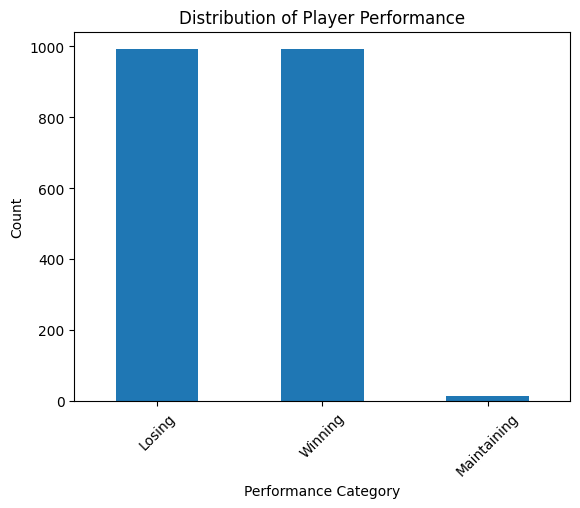

In [8]:
import matplotlib.pyplot as plt

# Plot the histogram (bar plot)
performance_distribution = player_df['performance'].value_counts()
print(performance_distribution)
performance_distribution.plot(kind='bar')
plt.title('Distribution of Player Performance')
plt.xlabel('Performance Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Drop performance as it's not well defined
player_df = player_df.drop(columns=['performance'])

Just noticed that palyers have a user_name and the games have timestamp so we can relate the players score from different games. Also, looks like ieshuaganocry is always one of the players. So, we can


*   Use ieshuaganocry to find the performance value of win/lose/maintain for each timestamp. We can filter out some games who seem to be too far apart based on timestamp as there might have other games happened in the middle.
*   Label other users using timestamp matching and reversing win/lose/maintain for ieshuaganocry to lose/win/maintain
* subsample ieshuaganocry to prevent over-fitting on this specific player's behavior
* Now we can find behavior changes based on the performance by data analysis or fit a model to behavior features as input and the performance as target and then use technique for explainability of the model like LIME and Shapley.


In [14]:
import numpy as np

perf_df = player_df[player_df['username'] == 'ieshuaganocry'][['timestamp', 'outcome', 'rating', 'rating_difference']]
perf_df = perf_df.sort_values(by='timestamp')
# Create new columns for next timestamp and next player elo score
print(perf_df['timestamp'].dtype)
print(perf_df['rating'].dtype)
perf_df['next_timestamp'] = perf_df['timestamp'].shift(-1)
perf_df['next_rating'] = perf_df['rating'].shift(-1)
perf_df.replace([np.inf, -np.inf], np.nan, inplace=True)
perf_df.dropna(subset=['next_timestamp', 'next_rating'], inplace=True)
perf_df['next_timestamp'] = perf_df['next_timestamp'].astype('int64')
perf_df['next_rating'] = perf_df['next_rating'].astype('int64')
print(perf_df)


int64
int64
       timestamp  outcome  rating  rating_difference  next_timestamp  \
0     1630368486        0    1901                 32      1630521672   
1006  1630521672        0    1901                 93      1630521800   
5     1630521800        1    1901                 93      1630522212   
1004  1630522212        1    1901                 93      1630522530   
3     1630522530        1    1901                 93      1630522980   
...          ...      ...     ...                ...             ...   
998   1643014690        0    1908                 15      1643032848   
997   1643032848        1    1914                  2      1643033219   
996   1643033219        0    1909                -64      1643033826   
1995  1643033826        0    1903                 16      1643040375   
1994  1643040375        0    1932                 60      1643044152   

      next_rating  
0            1901  
1006         1901  
5            1901  
1004         1901  
3            1901  
...

Only keep the games with close enough timestamps

In [15]:
print(perf_df.shape)
perf_df = perf_df[(perf_df['next_timestamp'] - perf_df['timestamp']) < 10000]
print(perf_df.shape)


(999, 6)
(739, 6)


Define performance as


*   1: next_rating > rating (winning)
*   0: next_rating = rating (maintaining score)
*   -1: next_rating < rating (losing)



In [16]:
pd.set_option('mode.chained_assignment', None)
perf_df.loc[:, 'performance'] = np.sign(perf_df['next_rating'] - perf_df['rating'])
print(perf_df)

       timestamp  outcome  rating  rating_difference  next_timestamp  \
1006  1630521672        0    1901                 93      1630521800   
5     1630521800        1    1901                 93      1630522212   
1004  1630522212        1    1901                 93      1630522530   
3     1630522530        1    1901                 93      1630522980   
1002  1630522980        1    1901                 93      1630524120   
...          ...      ...     ...                ...             ...   
1999  1643014122        0    1915                 -6      1643014690   
997   1643032848        1    1914                  2      1643033219   
996   1643033219        0    1909                -64      1643033826   
1995  1643033826        0    1903                 16      1643040375   
1994  1643040375        0    1932                 60      1643044152   

      next_rating  performance  
1006         1901            0  
5            1901            0  
1004         1901            0  
3  